In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import time
from django.contrib.gis.geos import Point, fromstr, GEOSGeometry
from datetime import datetime, timedelta
import vaex
import vaex.ml
from joblib import delayed, Parallel, load, parallel_backend
# from haversine import haversine, Unit

dir = Path.cwd()
dir = os.path.join(dir, '../')
outdir = os.path.join(dir, "output")
gtfs_records_zip = os.path.join(dir, "data", "GtfsRRecords.zip")
gtfs_csv_zip = os.path.join(outdir, "gtfsr_csv.zip")
gtfs_final_csv_path = os.path.join(outdir, "gtfsr.csv")
gtfs_processed_path = os.path.join(outdir, "gtfsr_processed.hdf5")
scats = os.path.join(outdir, "scats_model.json")
gtfsr_processing_temp = os.path.join(outdir, "processing_temp.hdf5")
gtfsr_arrival_means = os.path.join(outdir, "gtfsr_arrival_means.hdf5")


In [5]:
df = vaex.open(gtfs_processed_path)
df = df.sample(frac=1)
df.head(5)

#,trip_id,start_date,start_time,stop_sequence,departure,arrival,timestamp,stop_id,arrival_time,departure_time,shape_dist_traveled,direction,route_id,lat,lon,direction_angle,shape_dist_between,p_avg_vol
0,16250.4.60-49-b12-1.48.I,2.02101e+07,19:15:00,21,60,60,2021-01-29 19:29:31,8230DB001155,19:32:44,19:32:44,9200.43,1,60-49-b12-1,53.2968,-6.30713,62.914,529.6,84.1436
1,9204.2.60-38-b12-1.185.I,2.02101e+07,22:00:00,49,0,0,2021-01-30 22:08:03,8220DB000265,22:31:24,22:31:24,18016.1,1,60-38-b12-1,53.3534,-6.26206,116.993,542.15,65.7498
2,19837.4.60-9-b12-1.12.I,2.02101e+07,14:30:00,1,0,0,2021-01-26 14:01:02,8230DB004392,14:30:00,14:30:00,0,1,60-9-b12-1,53.307,-6.334,17.2954,0,162.79
3,20302.4.60-39-b12-1.201.I,2.02101e+07,10:45:00,69,120,120,2021-01-26 11:36:11,8220DB000335,11:43:40,11:43:40,24090.2,1,60-39-b12-1,53.3464,-6.25785,107.248,404.89,72.546
4,4655.10453.2-75-gad-1.60.I,2.02101e+07,09:15:00,62,180,180,2021-01-27 10:14:54,8230DB002515,10:10:00,10:10:00,18857.1,1,2-75-gad-1,53.2913,-6.31282,-92.1221,304.35,131.438


In [4]:
# len(df)
df.trip_id.value_counts()

17254.4.60-44-b12-1.246.O       409
18284.4.60-16-b12-1.128.O       399
21076.4.60-33-b12-1.171.I       399
19980.4.60-32X-b12-1.36.I       382
17159.4.60-40-b12-1.209.I       370
                               ... 
14889.3.60-68-b12-1.313.I         1
6496.10451.2-451-gad-1.276.I      1
7641.10466.2-270-gad-1.235.I      1
6529.10454.2-451-gad-1.276.I      1
6203.10451.2-451-gad-1.278.O      1
Length: 18978, dtype: int64

In [13]:
df.describe().T

,dtype,count,NA,mean,std,min,max
trip_id,str,1025854,0,--,--,--,--
start_date,int64,1025854,0,20210126.800474532,41.398219,20210122,20210131
start_time,str,1025854,0,--,--,--,--
stop_sequence,int64,1025854,0,31.50653211860557,20.63737,1,104
departure,int64,1025854,0,145.26119701244036,241.596064,-9000,5700
arrival,int64,1025854,0,139.45832447892195,233.956756,-7200,5400
timestamp,str,1025854,0,--,--,--,--
stop_id,str,1025854,0,--,--,--,--
arrival_time,str,1025854,0,--,--,--,--
departure_time,str,1025854,0,--,--,--,--


In [6]:
# remove outliers
outlier = 60*20
df = df[(df['arrival'] >= -outlier) & (df['arrival'] <= outlier) & (df['departure'] >= -outlier) & (df['departure'] <= outlier)]
# df.head(5)

In [6]:
# df[df.stop_sequence == 1]


In [7]:
one_route = vaex.concat([df[df['route_id'] == '2-75-gad-1'], df[df['route_id'] == '60-27-b12-1']])
# one_route = df[(df['route_id'] == '60-27-b12-1') and (df['route_id'] == '60-11-b12-1')]
one_route.export_hdf5('./output/one_route.hdf5')
# one_route


In [68]:
# # historical avg
# import vaex
# from datetime import datetime
# vx_df = vaex.open('./output/one_route.hdf5')

# # temp 
# def get_dt(dt, format):
#     return datetime.strptime(str(dt), format)
# def apply_dow(start_date, start_time, expected_time):
#     date = get_dt(start_date, "%Y%m%d")
#     if get_dt(start_time, "%H:%M:%S") > get_dt(expected_time, "%H:%M:%S"):
#         return (date + timedelta(days=1)).weekday()
#     return date.weekday()
# df_train['arr_dow'] = df_train.apply(apply_dow, ["start_date", "start_time", "arrival_time"])

# cols = ['trip_id', 'stop_id', 'arr_dow']
# trip_stops = df_train.groupby(cols, agg=[vaex.agg.mean('arrival')])

# df_train = multipe_column_join(df_train, trip_stops, cols, cols)


In [2]:
# df_train, df_test = vaex.open('./output/one_route.hdf5').ml.train_test_split(test_size=0.2, verbose=False)
# df_train, df_test = vaex.open(gtfs_processed_csv_path+'.hdf5').ml.train_test_split(test_size=0.2, verbose=False)

In [12]:
# model_out = os.path.join(outdir, "gtfsr_model.json")
start = time.time()

# join multiple vaex columns
def vaex_mjoin(x_left, x_right, keys_left: list, keys_right: list, how="left"):
    assert (
        type(keys_left) == list and type(keys_right) == list
    ), f"keys must be list and list, not {type(keys_left)} and {type(keys_right)}"

    assert len(keys_left) == len(
        keys_right
    ), f"lenghts of left and right keys dont match, left: {len(keys_left)} right: {len(keys_right)}"

    if len(keys_left) == 1:
        join_result = x_left.join(
            x_right, left_on=keys_left[0], right_on=keys_right[0], how=how, allow_duplication=True
        )

    elif len(keys_left) > 1:
        for idx, zp in enumerate(zip(keys_left, keys_right)):
            left_key, right_key = zp

            add_left = x_left[left_key]
            add_right = x_right[right_key]

            if not add_left.dtype == str:
                add_left = add_left.astype(str)
            if not add_right.dtype == str:
                add_right = add_right.astype(str)

            if idx == 0:
                x_right["group_right"] = add_right
                x_left["group_left"] = add_left
            else:
                x_right["group_right"] = x_right["group_right"] + "_" + add_right
                x_left["group_left"] = x_left["group_left"] + "_" + add_left

        x_right.drop(keys_right, inplace=True)
        join_result = x_left.join(x_right, left_on="group_left", right_on="group_right", how=how)
        join_result.drop(["group_left", "group_right"], inplace=True)
    return join_result

def get_dt(dt, format):
    return datetime.strptime(str(dt), format)

def apply_dow(start_date, start_time, expected_time):
    date = get_dt(start_date, "%Y%m%d")
    if get_dt(start_time, "%H:%M:%S") > get_dt(expected_time, "%H:%M:%S"):
        return (date + timedelta(days=1)).weekday()
    return date.weekday()

def transform_data(df):
    # is there a delay?
    def is_delay(arr):
        if arr > 0: return 1
        elif arr == 0: return 0
        elif arr < 0: return -1
    df['is_delayed'] = df['arrival'].apply(is_delay)

    # transform the features into more machine learning friendly vars
    pca_coord = vaex.ml.PCA(features=["lat", "lon"], n_components=2, prefix="pca")
    df = pca_coord.fit_transform(df)

    cycl_transform_angle = vaex.ml.CycleTransformer(features=["direction_angle"], n=360)
    df = cycl_transform_angle.fit_transform(df)

    df['t_dow'] = df['timestamp'].apply(lambda t: get_dt(t, "%Y-%m-%d %H:%M:%S").weekday())
    df['t_hour'] = df['timestamp'].apply(lambda t: get_dt(t, "%Y-%m-%d %H:%M:%S").hour)
    df['t_minute'] = df['timestamp'].apply(lambda t: get_dt(t, "%Y-%m-%d %H:%M:%S").minute)
    df['t_second'] = df['timestamp'].apply(lambda t: get_dt(t, "%Y-%m-%d %H:%M:%S").second)

    df['arr_dow'] = df.apply(apply_dow, ["start_date", "start_time", "arrival_time"])
    df['arr_hour'] = df['arrival_time'].apply(lambda t: get_dt(t, "%H:%M:%S").hour)
    df['arr_minute'] = df['arrival_time'].apply(lambda t: get_dt(t, "%H:%M:%S").minute)
    df['arr_second'] = df['arrival_time'].apply(lambda t: get_dt(t, "%H:%M:%S").second)

    # df['dep_dow'] = df.apply(apply_dow, ["start_date", "start_time", "departure_time"])
    # df['dep_hour'] = df['departure_time'].apply(lambda t: get_dt(t, "%H:%M:%S").hour)
    # df['dep_minute'] = df['departure_time'].apply(lambda t: get_dt(t, "%H:%M:%S").minute)
    # df['dep_second'] = df['departure_time'].apply(lambda t: get_dt(t, "%H:%M:%S").second)

    cycl_transform_dow = vaex.ml.CycleTransformer(features=["t_dow", 'arr_dow'], n=7)
    df = cycl_transform_dow.fit_transform(df)

    cycl_transform_hour = vaex.ml.CycleTransformer(features=["t_hour", 'arr_hour'], n=24)
    df = cycl_transform_hour.fit_transform(df)

    cycl_transform_minute = vaex.ml.CycleTransformer(features=["t_minute", 't_second', 'arr_minute', 'arr_second'], n=60)
    df = cycl_transform_minute.fit_transform(df)

    label_encoder = vaex.ml.LabelEncoder(features=['trip_id', 'route_id'], prefix='label_encode_')
    df = label_encoder.fit_transform(df)

    df['arrival'] = df['arrival'].apply(lambda t: 0 if t == 0 else t/60)
    df['departure'] = df['departure'].apply(lambda t: 0 if t == 0 else t/60)
    df['arrival_mean'] = df['arrival'].apply(lambda t: 0 if t == 0 else t/60)

    standard_scaler = vaex.ml.StandardScaler(features=["arrival_mean"])
    df = standard_scaler.fit_transform(df)

    minmax_scaler = vaex.ml.MinMaxScaler(features=["p_avg_vol", "shape_dist_traveled", "shape_dist_between"])
    df = minmax_scaler.fit_transform(df)

    print("dataWrangling done, ready to create model, time: {}s".format(round(time.time() - start)))
    return df

vx_df = vaex.open('../output/one_route.hdf5')
vx_df['arr_dow'] = vx_df.apply(apply_dow, ["start_date", "start_time", "arrival_time"])
# add arrival historical mean
cols = ['trip_id', 'stop_id', 'arr_dow']
vx_df = vaex_mjoin(vx_df, vaex.open(gtfsr_arrival_means), cols, cols)
vx_df = vx_df.drop(['arr_dow'])

vx_df = vx_df.shallow_copy()

df_train, df_test = vx_df.ml.train_test_split(test_size=0.4, verbose=False)
transformed_df = transform_data(df_train)
transformed_df

dataWrangling done, ready to create model, time: 3s


#,trip_id,start_date,start_time,stop_sequence,departure,arrival,timestamp,stop_id,arrival_time,departure_time,shape_dist_traveled,direction,route_id,lat,lon,direction_angle,shape_dist_between,p_avg_vol,arrival_mean,is_delayed,pca0,pca1,direction_angle_x,direction_angle_y,t_dow,t_hour,t_minute,t_second,arr_dow,arr_hour,arr_minute,arr_second,t_dow_x,t_dow_y,arr_dow_x,arr_dow_y,t_hour_x,t_hour_y,arr_hour_x,arr_hour_y,t_minute_x,t_minute_y,t_second_x,t_second_y,arr_minute_x,arr_minute_y,arr_second_x,arr_second_y,label_encode_trip_id,label_encode_route_id,standard_scaled_arrival_mean,minmax_scaled_p_avg_vol,minmax_scaled_shape_dist_traveled,minmax_scaled_shape_dist_between
0,4984.10466.2-75-gad-1.60.I,20210130,17:55:00,16,3.0,3.0,2021-01-30 18:16:29,8250DB002060,18:13:00,18:13:00,4532.25,1,2-75-gad-1,53.2739549356955,-6.17508567922552,-92.1220554253009,377.04,107.91415287041144,0.05,1,0.06366191469351898,0.1083325047798536,-0.03702838724361924,-0.9993142141179303,5,18,16,29,5,18,13,0,-0.2225209339563146,-0.9749279121818236,-0.2225209339563146,-0.9749279121818236,-1.8369701987210297e-16,-1.0,-1.8369701987210297e-16,-1.0,-0.10452846326765333,0.9945218953682734,-0.9945218953682734,0.10452846326765329,0.20791169081775923,0.9781476007338057,1.0,0.0,0,0,-0.027158189101129143,0.09923985687013316,0.15275834605406713,0.3148112585269727
1,4791.10455.2-75-gad-1.59.O,20210129,12:45:00,66,1.0,1.0,2021-01-29 13:54:37,8250DB002015,14:05:00,14:05:00,21810.23,0,2-75-gad-1,53.2755348428749,-6.1790671072586,87.88831962900996,444.5,0.0,0.016666666666666666,1,0.060931896191338916,0.10503176624797018,0.036847431961062965,0.9993209027924288,4,13,54,37,4,14,5,0,-0.9009688679024191,-0.433883739117558,-0.9009688679024191,-0.433883739117558,-0.9659258262890683,-0.2588190451025208,-0.8660254037844388,-0.4999999999999997,0.8090169943749473,-0.5877852522924734,-0.7431448254773942,-0.6691306063588582,0.8660254037844387,0.49999999999999994,1.0,0.0,1,0,-0.5050929094632959,0.0,0.7351083152647795,0.37113729157447317
2,4651.10454.2-75-gad-1.59.O,20210128,09:05:00,7,0.0,0.0,2021-01-28 09:30:01,8230DB002605,09:14:00,09:14:00,2470.04,0,2-75-gad-1,53.2840559727612,-6.35991184833953,87.88831962900996,338.23,266.29487177516506,0.0,0,-0.09350125546224475,0.010544562344431324,0.036847431961062965,0.9993209027924288,3,9,30,1,3,9,14,0,-0.900968867902419,0.43388373911755823,-0.900968867902419,0.43388373911755823,-0.7071067811865475,0.7071067811865476,-0.7071067811865475,0.7071067811865476,-1.0,5.66553889764798e-16,0.9945218953682733,0.10452846326765346,0.10452846326765346,0.9945218953682733,1.0,0.0,2,0,-0.7440602696443792,0.24488970405904725,0.08325207680233614,0.28240667295665706
3,4768.10447.2-75-gad-1.59.O,20210124,11:55:00,21,5.0,5.0,2021-01-24 12:26:20,8230DB001134,12:20:00,12:20:00,8071.77,0,2-75-gad-1,53.2955073210834,-6.29837004294659,87.88831962900996,219.05000000000015,18.485981855197007,0.08333333333333333,1,-0.034042019296565265,0.030118177851351076,0.036847431961062965,0.9993209027924288,6,12,26,20,6,12,20,0,0.6234898018587334,-0.7818314824680299,0.6234898018587334,-0.7818314824680299,-1.0,1.2246467991473532e-16,-1.0,1.2246467991473532e-16,-0.913545457642601,0.40673664307580004,-0.4999999999999998,0.8660254037844387,-0.4999999999999998,0.8660254037844387,1.0,0.0,3,0,0.4507765312610374,0.01700005184321506,0.27205697720311933,0.1828967912697152
4,4830.10454.2-75-gad-1.60.I,20210128,13:55:00,32,-1.0,-1.0,2021-01-28 14:19:40,8250DB002886,14:31:00,14:31:00,9812.12,1,2-75-gad-1,53.2883466717405,-6.23124637559987,-92.1220554253009,278.2300000000014,111.57328251051128,-0.016666666666666666,-1,0.021354859520147738,0.06869339573085859,-0.03702838724361924,-0.9993142141179303,3,14,19,40,3,14,31,0,-0.900968867902419,0.43388373911755823,-0.900968867902419,0.43388373911755823,-0.8660254037844388,-0.4999999999999997,-0.8660254037844388,-0.4999999999999997,-0.40673664307580004,0.913545457642601,-0.5000000000000004,-0.8660254037844384,-0.9945218953682734,-0.10452846326765305,1.0,0.

In [11]:
# df_train.state_load(os.path.join(outdir, "gtfsr_model.json"))
# df_train

# it works to load a model

In [ ]:
# def train_trip(trip_id, start_date, start_time, direction, route_id):
#     d = transformed_df
#     t = d[(d['trip_id'] == trip_id) & (d['start_date'] == start_date) & (d['start_time'] == start_time) & (d['direction'] == direction) & (d['route_id'] == route_id)]
#     # print(t)
#     return trip_id

# cols = ['trip_id', 'start_date', 'start_time', 'direction', 'route_id' ]
# trips = one_route.groupby(cols).agg('count')
# trips.apply(train_trip, cols)

In [13]:
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeRegressor
from vaex.ml.sklearn import Predictor, IncrementalPredictor
import lightgbm 
import xgboost as xgb
from sklearn.linear_model import SGDRegressor
import multiprocessing
from sklearn.model_selection import GridSearchCV

start = time.time()

def train_gtfsr(df):
    feats = df.get_column_names(regex="pca") + \
        df.get_column_names(regex=".*_x") + \
        df.get_column_names(regex=".*_y") + \
        df.get_column_names(regex="standard_scaled_*") + \
        df.get_column_names(regex="label_encode_*") + \
        df.get_column_names(regex="minmax_scaled_*") + \
        ["stop_sequence", 'direction', 'is_delayed']
        

    target = "arrival"
    prediction_name = "p_arrival"

    lgbm_params = {
        'boosting_type': 'gbdt',
        'learning_rate': 0.3,
        'n_estimators': 300,
        'max_depth': 50,
        'num_leaves': 50,
        'num_iterations': 300,
    }

    # clf = GridSearchCV(
    #     lightgbm.LGBMRegressor(n_jobs=-1), 
    #     {
    #         'num_leaves': [15],
    #         'n_estimators': [300],
    #         'depth': [10],
    #         'learning_rate' : [0.3],
    #         'l2_leaf_reg': [1],
    #         'iterations': [300]
    #     },
    #     verbose=1, n_jobs=-1, cv = 5
    # )
    # search = clf.fit(df[feats].values, df[target].values)
    # print(search.best_params_)

    # create randomForestRegressor, xgboost, lstm, lgbm

    # 2 layer ensemble, 1. Decision Tree, 2. XGBoost

    models = [
        # # creating svr
        # Predictor(
        #     features=feats,
        #     target=target,
        #     model=SVR(max_iter=10000),
        #     prediction_name=prediction_name+'_svr'
        # ),
        # lightgmb Regressor
        Predictor(
            features=feats, 
            target=target,
            prediction_name=prediction_name+'_lgbm',
            model=lightgbm.LGBMRegressor(**lgbm_params, n_jobs=-1)
        ),
        # XGBoost Regressor
        Predictor(
            features=feats, 
            target=target,
            prediction_name=prediction_name+'_xgb',
            model=xgb.XGBRegressor(max_depth=50, min_child_weight=1, n_estimators=300, n_jobs=-1, learning_rate=0.3)
        ),
        # MLP
        # IncrementalPredictor(
        #     features=feats, 
        #     target=target,
        #     model=MLPRegressor(learning_rate='constant', hidden_layer_sizes=15), 
        #     prediction_name=prediction_name+'_mlp',
        #     batch_size=11_000_000, 
        #     num_epochs=100,
        # )
    ]

    # here we fit and train the model
    for model in models:
        model.fit(df=df)
        df = model.transform(df)
        print("\n\nmodel created, time: {}s".format(round(time.time() - start)))

    # weighted average ensemble
    prediction_final = (
        # df.p_arrival_mlp.astype('int') * 0.6 +
        df.p_arrival_lgbm.astype('int') * 0.5 +
        df.p_arrival_xgb.astype('int') * 0.5 
        # df.p_arrival_svr.astype('int') * 0.5 
    )
    df[prediction_name+'_final'] = prediction_final


    # dump(value=vaex_model, filename=model_out, compress=3)
    # print("model written to output, time: {}s".format(round(time.time() - start)))


    # df['p_arrival'] = df['p_arrival_mlp'].apply(lambda t: round(t))
    # df['arrival'] = df['arrival'].apply(lambda t: round(t))

    return df
trained_df = train_gtfsr(transformed_df)
trained_df



model created, time: 16s


model created, time: 22s


#,trip_id,start_date,start_time,stop_sequence,departure,arrival,timestamp,stop_id,arrival_time,departure_time,shape_dist_traveled,direction,route_id,lat,lon,direction_angle,shape_dist_between,p_avg_vol,arrival_mean,is_delayed,pca0,pca1,direction_angle_x,direction_angle_y,t_dow,t_hour,t_minute,t_second,arr_dow,arr_hour,arr_minute,arr_second,t_dow_x,t_dow_y,arr_dow_x,arr_dow_y,t_hour_x,t_hour_y,arr_hour_x,arr_hour_y,t_minute_x,t_minute_y,t_second_x,t_second_y,arr_minute_x,arr_minute_y,arr_second_x,arr_second_y,label_encode_trip_id,label_encode_route_id,standard_scaled_arrival_mean,minmax_scaled_p_avg_vol,minmax_scaled_shape_dist_traveled,minmax_scaled_shape_dist_between,p_arrival_lgbm,p_arrival_xgb,p_arrival_final
0,4984.10466.2-75-gad-1.60.I,20210130,17:55:00,16,3.0,3.0,2021-01-30 18:16:29,8250DB002060,18:13:00,18:13:00,4532.25,1,2-75-gad-1,53.2739549356955,-6.17508567922552,-92.1220554253009,377.04,107.91415287041144,0.05,1,0.06366191469351898,0.1083325047798536,-0.03702838724361924,-0.9993142141179303,5,18,16,29,5,18,13,0,-0.2225209339563146,-0.9749279121818236,-0.2225209339563146,-0.9749279121818236,-1.8369701987210297e-16,-1.0,-1.8369701987210297e-16,-1.0,-0.10452846326765333,0.9945218953682734,-0.9945218953682734,0.10452846326765329,0.20791169081775923,0.9781476007338057,1.0,0.0,0,0,-0.027158189101129143,0.09923985687013316,0.15275834605406713,0.3148112585269727,2.9985196055789785,3.000000238418579,2.5
1,4791.10455.2-75-gad-1.59.O,20210129,12:45:00,66,1.0,1.0,2021-01-29 13:54:37,8250DB002015,14:05:00,14:05:00,21810.23,0,2-75-gad-1,53.2755348428749,-6.1790671072586,87.88831962900996,444.5,0.0,0.016666666666666666,1,0.060931896191338916,0.10503176624797018,0.036847431961062965,0.9993209027924288,4,13,54,37,4,14,5,0,-0.9009688679024191,-0.433883739117558,-0.9009688679024191,-0.433883739117558,-0.9659258262890683,-0.2588190451025208,-0.8660254037844388,-0.4999999999999997,0.8090169943749473,-0.5877852522924734,-0.7431448254773942,-0.6691306063588582,0.8660254037844387,0.49999999999999994,1.0,0.0,1,0,-0.5050929094632959,0.0,0.7351083152647795,0.37113729157447317,0.9959073565265123,1.000002384185791,0.5
2,4651.10454.2-75-gad-1.59.O,20210128,09:05:00,7,0.0,0.0,2021-01-28 09:30:01,8230DB002605,09:14:00,09:14:00,2470.04,0,2-75-gad-1,53.2840559727612,-6.35991184833953,87.88831962900996,338.23,266.29487177516506,0.0,0,-0.09350125546224475,0.010544562344431324,0.036847431961062965,0.9993209027924288,3,9,30,1,3,9,14,0,-0.900968867902419,0.43388373911755823,-0.900968867902419,0.43388373911755823,-0.7071067811865475,0.7071067811865476,-0.7071067811865475,0.7071067811865476,-1.0,5.66553889764798e-16,0.9945218953682733,0.10452846326765346,0.10452846326765346,0.9945218953682733,1.0,0.0,2,0,-0.7440602696443792,0.24488970405904725,0.08325207680233614,0.28240667295665706,-0.0010533515130609103,3.7858701489312807e-06,0.0
3,4768.10447.2-75-gad-1.59.O,20210124,11:55:00,21,5.0,5.0,2021-01-24 12:26:20,8230DB001134,12:20:00,12:20:00,8071.77,0,2-75-gad-1,53.2955073210834,-6.29837004294659,87.88831962900996,219.05000000000015,18.485981855197007,0.08333333333333333,1,-0.034042019296565265,0.030118177851351076,0.036847431961062965,0.9993209027924288,6,12,26,20,6,12,20,0,0.6234898018587334,-0.7818314824680299,0.6234898018587334,-0.7818314824680299,-1.0,1.2246467991473532e-16,-1.0,1.2246467991473532e-16,-0.913545457642601,0.40673664307580004,-0.4999999999999998,0.8660254037844387,-0.4999999999999998,0.8660254037844387,1.0,0.0,3,0,0.4507765312610374,0.01700005184321506,0.27205697720311933,0.1828967912697152,5.000403391271086,4.999997615814209,4.5
4,4830.10454.2-75-gad-1.60.I,20210128,13:55:00,32,-1.0,-1.0,2021-01-28 14:19:40,8250DB002886,14:31:00,14:31:00,9812.12,1,2-75-gad-1,53.2883466717405,-6.23124637559987,-92.1220554253009,278.2300000000014,111.57328251051128,-0.016666666666666666,-1,0.021354859520147738,0.06869339573085859,-0.03702838724361924,-0.9993142141179303,3,14,19,40,3,14,31,0,-0.900968867902419,0.43388373911755823,-0.900968867902419,0.4338837

In [5]:
trained_df[['arrival'] + trained_df.get_column_names(regex='^p_arrival')].head(15)
# trained_df[['arrival', 'arrival_mean'] + trained_df.get_column_names(regex='^p_arrival')].head(15)

#,arrival,p_arrival_lgbm,p_arrival_xgb,p_arrival_final
0,7.0,6.345285136444535,6.999880790710449,6.0
1,2.0,2.8383961515088147,2.0007011890411377,2.0
2,2.0,2.736011489134787,2.0010221004486084,2.0
3,0.0,0.04272163206784453,1.6148402437465847e-06,0.0
4,0.0,-0.12101720034725408,1.6148402437465847e-06,0.0
...,...,...,...,...
10,-2.0,-1.7353582452369167,-1.9998588562011719,-1.0
11,2.0,2.435052576501187,1.9995900392532349,1.5
12,0.0,-0.10843519460286499,1.6148402437465847e-06,0.0
13,0.0,-0.18029182380500083,1.6148402437465847e-06,0.0


In [9]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error, r2_score, mean_absolute_error
def binary_metrics(y_true, y_pred):
    # try:
    #     acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    #     print(f'Accuracy: {acc:.3f}')
    #     roc = roc_auc_score(y_true=y_true, y_score=y_pred)
    #     print(f'roc-auc: {roc:.3f}')
    #     f1 = f1_score(y_true=y_true, y_pred=y_pred)
    #     print(f'f1 score: {f1:.3f}')
    # except: pass
    try: 
        mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
        print(f'mae: {mae:.3f}')
        mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
        print(f'mse: {mse:.3f}')
        r2 = r2_score(y_true=y_true, y_pred=y_pred)
        print(f'r2: {r2:.3f}')
    except: pass

# State transfer
state_new = trained_df.state_get()
df_test.state_set(state_new)

pred_columns = trained_df.get_column_names(regex='^p_arrival_')
for i in pred_columns:
    print(i)
    y_true=df_test.arrival.values
    # if '_svc' in i:
    #     y_true=df_test.is_delayed.values
    binary_metrics(y_true=y_true, y_pred=df_test[i].values)
    print(' ')


p_arrival_lgbm
mae: 0.002
mse: 0.004
r2: 0.999
 
p_arrival_xgb
mae: 0.000
mse: 0.000
r2: 1.000
 
p_arrival_final
mae: 0.366
mse: 0.263
r2: 0.960
 


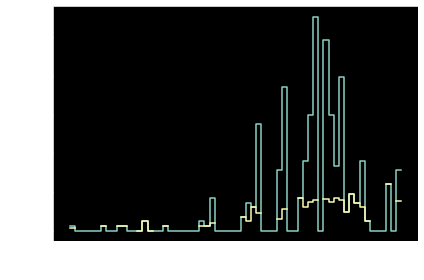

In [105]:
# Check the class balance
trip = df_train[(df_train.trip_id == '7857.2.60-44-b12-1.244.I') & (df_train.start_time == '13:30:00')] 

# trip.plot1d(trip.arrival)
# trip.plot1d(trip.stop_sequence, what='sum(p_avg_vol)')
trip.plot1d(trip.stop_sequence, what='sum(arrival)')
# trip.plot1d(trip.stop_sequence, what='sum(shape_dist_between)')
trip.plot1d(trip.stop_sequence, what='mean(departure)')


array([[<AxesSubplot:title={'center':'start_date'}>,
        <AxesSubplot:title={'center':'stop_sequence'}>,
        <AxesSubplot:title={'center':'departure'}>],
       [<AxesSubplot:title={'center':'arrival'}>,
        <AxesSubplot:title={'center':'shape_dist_traveled'}>,
        <AxesSubplot:title={'center':'direction'}>],
       [<AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'lon'}>,
        <AxesSubplot:title={'center':'direction_angle'}>],
       [<AxesSubplot:title={'center':'shape_dist_between'}>,
        <AxesSubplot:title={'center':'p_avg_vol'}>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

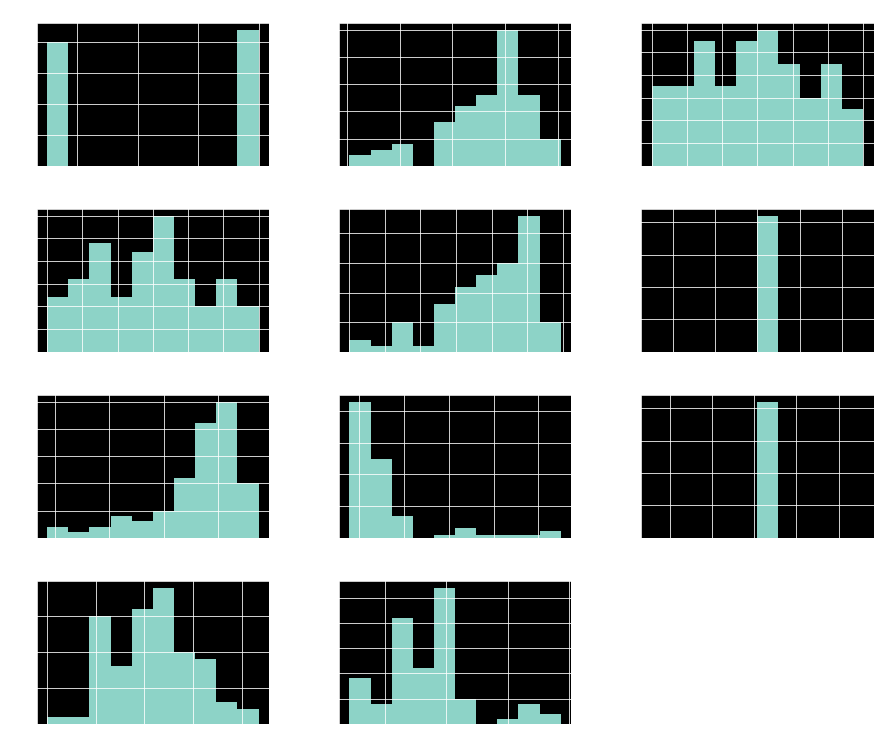

In [121]:
trip.to_pandas_df().hist(figsize=(15,30),layout=(9,3))


In [27]:
# one_route = vaex.open('./output/one_route.hdf5')
# one_route = transform_data(one_route)
# one_route.export_csv('./output/one_route.csv')
one_route = pd.read_csv('./output/one_route.csv').sort_values('timestamp', ascending=False)
# one_route

dataWrangling done, ready to create model, time: 32s


In [29]:
pd.set_option('display.max_columns', 500)

one_route

,trip_id,start_date,start_time,stop_sequence,departure,arrival,timestamp,stop_id,arrival_time,departure_time,shape_dist_traveled,direction,route_id,lat,lon,direction_angle,shape_dist_between,p_avg_vol,pca0,pca1,direction_angle_x,direction_angle_y,t_dow,t_hour,t_minute,t_second,arr_dow,arr_hour,arr_minute,arr_second,dep_dow,dep_hour,dep_minute,dep_second,t_dow_x,t_dow_y,arr_dow_x,arr_dow_y,t_hour_x,t_hour_y,arr_hour_x,arr_hour_y,t_minute_x,t_minute_y,t_second_x,t_second_y,arr_minute_x,arr_minute_y,arr_second_x,arr_second_y,standard_scaled_p_avg_vol,standard_scaled_shape_dist_traveled,standard_scaled_shape_dist_between
31829,12962.3.60-27-b12-1.152.O,20210131,23:30:00,22,1.0,1.0,2021-01-31 23:43:13,8220DB001276,23:41:11,23:41:11,6159.22,0,60-27-b12-1,53.384331,-6.202915,-122.982189,149.72,7.340456,0.092725,0.000091,-0.544378,-0.838840,6,23,43,13,6,23,41,11,6,23,41,11,0.623490,-0.781831,0.623490,-0.781831,0.965926,-0.258819,0.965926,-0.258819,-0.207912,-0.978148,0.207912,0.978148,-4.067366e-01,-9.135455e-01,0.406737,0.913545,-1.135576,-1.126997,-1.309726
26461,12962.3.60-27-b12-1.152.O,20210131,23:30:00,27,0.0,0.0,2021-01-31 23:43:13,8220DB000664,23:44:16,23:44:16,7718.38,0,60-27-b12-1,53.374719,-6.219508,-122.982189,327.76,17.050621,0.073552,0.000373,-0.544378,-0.838840,6,23,43,13,6,23,44,16,6,23,44,16,0.623490,-0.781831,0.623490,-0.781831,0.965926,-0.258819,0.965926,-0.258819,-0.207912,-0.978148,0.207912,0.978148,-1.045285e-01,-9.945219e-01,-0.104528,0.994522,-1.005720,-0.923679,-0.426255
28490,13002.3.60-27-b12-1.149.I,20210131,22:40:00,65,12.0,12.0,2021-01-31 23:29:42,8220DB001196,23:24:13,23:24:13,21471.02,1,60-27-b12-1,53.377788,-6.214915,61.738723,515.25,22.216403,0.079058,-0.000061,0.473493,0.880798,6,23,29,42,6,23,24,13,6,23,24,13,0.623490,-0.781831,0.623490,-0.781831,0.965926,-0.258819,0.965926,-0.258819,-0.994522,0.104528,-0.309017,-0.951057,-8.090170e-01,5.877853e-01,0.207912,0.978148,-0.936637,0.869691,0.504110
26527,13002.3.60-27-b12-1.149.I,20210131,22:40:00,87,11.0,11.0,2021-01-31 23:29:42,8220DB006115,23:36:25,23:36:25,27787.14,1,60-27-b12-1,53.400127,-6.184218,61.738723,598.03,24.344710,0.116756,-0.004560,0.473493,0.880798,6,23,29,42,6,23,36,25,6,23,36,25,0.623490,-0.781831,0.623490,-0.781831,0.965926,-0.258819,0.965926,-0.258819,-0.994522,0.104528,-0.309017,-0.951057,-8.090170e-01,-5.877853e-01,-0.866025,0.500000,-0.908175,1.693324,0.914882
11614,13002.3.60-27-b12-1.149.I,20210131,22:40:00,48,13.0,3.0,2021-01-31 23:29:42,8220DB000298,23:15:48,23:15:48,16843.88,1,60-27-b12-1,53.348201,-6.256392,61.738723,776.06,15.709297,0.028414,0.005497,0.473493,0.880798,6,23,29,42,6,23,15,48,6,23,15,48,0.623490,-0.781831,0.623490,-0.781831,0.965926,-0.258819,0.965926,-0.258819,-0.994522,0.104528,-0.309017,-0.951057,2.832769e-16,1.000000e+00,0.309017,-0.951057,-1.023658,0.266303,1.798304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40992,17681.4.60-27-b12-1.149.I,20210122,10:10:00,37,4.0,4.0,2021-01-22 11:13:19,8220DB001436,10:42:00,10:42:00,12968.84,1,60-27-b12-1,53.330885,-6.296512,61.738723,274.76,118.281248,-0.015052,0.001010,0.473493,0.880798,4,11,13,19,4,10,42,0,4,10,42,0,-0.900969,-0.433884,-0.900969,-0.433884,-0.965926,0.258819,-0.866025,0.500000,0.207912,0.978148,-0.406737,0.913545,-3.090170e-01,-9.510565e-01,1.000000,0.000000,0.348055,-0.239009,-0.689252
3012,17615.4.60-27-b12-1.151.O,20210122,10:20:00,5,0.0,0.0,2021-01-22 11:13:19,8220DB001258,10:23:44,10:23:44,1536.54,0,60-27-b12-1,53.398187,-6.190827,-118.210196,634.97,74.666661,0.110041,-0.006096,-0.472708,-0.881219,4,11,13,19,4,10,23,44,4,10,23,44,-0.900969,-0.433884,-0.900969,-0.433884,-0.965926,0.258819,-0.866025,0.500000,0.207912,0.978148,-0.406737,0.913545,-7.431448e-01,6.691306e-01,-0.104528,-0.994522,-0.235211,-1.729803,1.098186
14934,17760.4.60-27-b12-1.149.I,20210122,11:30:00,1,0.0,0.0,

In [4]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking


model = Sequential()

# # Create LSTM RNN
# model.add(LSTM(units=100, return_sequence=True, ))


In [24]:
df.plot_widget(df.lon, df.lat, shape=512, colormap='plasma', f='log1p', limits='minmax')

Heatmap(children=[ToolsToolbar(interact_value=None, supports_normalize=False, template='<template>\n  <v-toolb…